<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/bert_finetuning_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import transformers
import os

from transformers import TFMT5ForConditionalGeneration, MT5Tokenizer, DataCollatorForSeq2Seq

In [4]:
print(tf.__version__)

2.17.1


# 1. Duomenų paruošimas

Atliksime sentimentų analizę, naudojant iš anksto apmokytą BERT modelį.

Naudosime duomenis iš [Yelp Open Dataset](https://www.yelp.com/dataset). Tai bus atsiliepimai apie maisto restoranus.

In [5]:
if not os.path.exists("/content/hfDataset"):
  hfDataset = load_dataset("antash420/text-summarization-alpaca-format")
  hfDataset.save_to_disk("/content/hfDataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/647 [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/268M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/245M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/264M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/68.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/59.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Saving the dataset (0/6 shards):   0%|          | 0/287113 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13368 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11490 [00:00<?, ? examples/s]

In [6]:
print("Input: ", hfDataset['test']['input'][0])
print("Output: ", hfDataset['test']['output'][0])

Input:  (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's cere

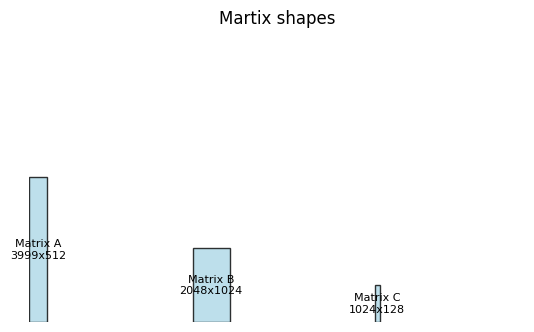

In [7]:
def plot_matrices(matrices, labels=None, max_height=10, max_width=10):
    """
    Visualizes the shapes of large NumPy matrices as scaled rectangles.

    Parameters:
    - matrices: List of NumPy arrays
    - labels: Optional list of labels for the matrices
    - max_height: Maximum height of the largest rectangle in the plot
    - max_width: Maximum width of the largest rectangle in the plot
    """
    fig, ax = plt.subplots()
    current_x = 0

    # Determine scaling factors
    max_rows = max(matrix.shape[0] for matrix in matrices)
    max_cols = max(matrix.shape[1] for matrix in matrices)
    scale = max(max_rows, max_cols)

    for i, matrix in enumerate(matrices):
        rows, cols = matrix.shape
        scaled_rows = rows / scale
        scaled_cols = cols / scale

        # Draw rectangle
        rect = plt.Rectangle(
            (current_x, 0), scaled_cols, scaled_rows, edgecolor='black', facecolor='lightblue', alpha=0.8
        )
        ax.add_patch(rect)

        # Add label
        if labels and i < len(labels):
            ax.text(
                current_x + scaled_cols / 2, scaled_rows / 2,
                f"{labels[i]}\n{rows}x{cols}", ha='center', va='center', fontsize=8
            )

        current_x += scaled_cols + 1  # Add space between matrices

    # Set limits and display
    ax.set_xlim(0, current_x)
    ax.set_ylim(0, max(matrix.shape[0] / scale for matrix in matrices) + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.xlabel('Columns (scaled)')
    plt.ylabel('Rows (scaled)')
    plt.title('Martix shapes')
    plt.show()

# Example usage with large matrices
matrices = [
    np.random.rand(3999, 512),
    np.random.rand(2048, 1024),
    np.random.rand(1024, 128)
]
labels = ["Matrix A", "Matrix B", "Matrix C"]
plot_matrices(matrices, labels)


In [34]:
from tensorflow.keras.initializers import RandomNormal
initializer = RandomNormal(mean=0.0, stddev=0.05, seed=42)

tokenizer = MT5Tokenizer.from_pretrained("content/MyDrive/Colab/t5-text-summarization", legacy=False)
model = TFMT5ForConditionalGeneration.from_pretrained("content/MyDrive/Colab/t5-text-summarization.t5")

OSError: Incorrect path_or_model_id: 'content/MyDrive/Colab/t5-text-summarization'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

Kiek turime apmokymo duomenų (mėginių)?

In [9]:
print("Apmokymo duomenu: ", len(hfDataset['train']))
print("Testavimo duomenu: ", len(hfDataset['test']))

Apmokymo duomenu:  287113
Testavimo duomenu:  11490


Toliau naudosime tik dalį atsiliepimų viso proceso greitinimui:

In [10]:
n_samples = 2000
small_train_dataset = hfDataset["train"].shuffle(seed=42).select(range(n_samples))
small_eval_dataset = hfDataset["test"].shuffle(seed=42).select(range(n_samples))
len(small_eval_dataset)

2000

In [11]:
small_train_dataset['text'][0]

"Below is an instruction that describes a task, paired with an input that provides further context.Write a response that appropriately completes the request.\n\n### Instruction: Given the input article. Summarize only the important information in 2-3 lines, ignoring any unnecessary details.### Input: \nBy . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of th

In [12]:
def tokenize(text):
  inputs = tokenizer(
      text['text'], max_length=512, truncation=True, padding="max_length"
  )
  outputs = tokenizer(
      text["output"], max_length=128, truncation=True, padding="max_length"
  )
  tokens = inputs
  tokens["labels"] = outputs["input_ids"]
  return inputs


encoded_train = small_train_dataset.map(tokenize, batched=True)
encoded_eval = small_eval_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
tokenizer.decode(encoded_train['labels'][0])

'John and . Audrey Cook were discovered alongside their daughter, Maureen . They were found at Tremarle Home Park in Cornwall . Investigators say the three died of carbon monoxide . poisoning .</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

Pastebekime kad po tokenizavimo mūsų `Dataset` objectas gavo naujas savybes (stulpelius, raktažodžius) - `'input_ids'`, `'token_type_ids'` ir `'attention_mask'`:

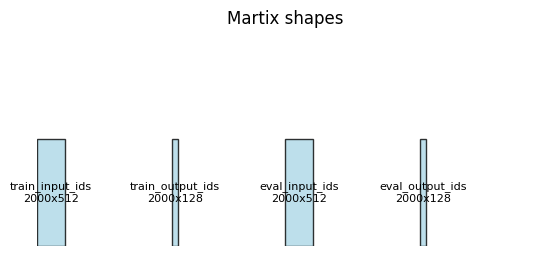

In [13]:
plot_matrices([np.matrix(encoded_train['input_ids']),
               np.matrix(encoded_train['labels']),
               np.matrix(encoded_eval['input_ids']),
               np.matrix(encoded_eval['labels'])],
              ["train_input_ids",
               "train_output_ids",
               "eval_input_ids",
               "eval_output_ids"])

Paruošiame klasifikavimo žymių žodynus:

## 2. Modelio inicializavimas ir derinimas

In [14]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=tokenizer.pad_token_id,
    pad_to_multiple_of=8,
    return_tensors="np"
)

tf_train_dataset = model.prepare_tf_dataset(
    encoded_train,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)

tf_eval_dataset = model.prepare_tf_dataset(
    encoded_eval,
    collate_fn=data_collator
)

Ką tik gautas įspėjimas apie kai kuriuos išmestus svorius yra normalus - šiuo atveju mes pašalinome modelio bloką, atsakingą už maskuotą kalbos modeliavimą - tai yra įprasta BERT modelio užduotis, o mes norime atlikti sentimentų analizę (teksto klasifikavimą), dėl ko mums ir reikia papildomas modelio derinimas.

Norime įkelsti mūsų duomenis kaip Tensorflow duomenų rinkinius - tai bus padaryta automatiškai ir atitiks modelio architektūrą:

In [15]:
batch_size = 16

# def convert_to_tf_dataset(tokenized_dataset, batch_size=16):
#     def gen():
#         for data in tokenized_dataset:
#             yield {
#                 "input_ids": data["input_ids"],
#                 "attention_mask": data["attention_mask"],
#             }, data["output_ids"]

#     return tf.data.Dataset.from_generator(
#         gen,
#         output_signature=(
#             {
#                 "input_ids": tf.TensorSpec(shape=(512,), dtype=tf.int32),
#                 "attention_mask": tf.TensorSpec(shape=(512,), dtype=tf.int32),
#             },
#             tf.TensorSpec(shape=(128,), dtype=tf.int32),
#         ),
#     ).batch(batch_size)

# # Create train and validation datasets
# train_dataset = convert_to_tf_dataset(encoded_train)
# val_dataset = convert_to_tf_dataset(encoded_eval)

In [16]:
tf_train_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(16, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 128), dtype=tf.int64, name=None))>

Visi `transformers` modeliai pagal nutylėjimą gali patys pasirinkti protingą nuostolių funkciją, todėl mums nereikis dėti `loss` parametro į `compile()`. Tuo metu `transformers` rekomenduoja sukonstruoti `AdamW` tipo optimizatorių patiems:

In [27]:
num_epochs = 20

batches_per_epoch = len(encoded_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = transformers.create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, metrics=['accuracy'])

Laikas fittinti modelį:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [31]:
if os.path.exists("/content/drive/My Drive/Colab/t5-text-summarization.h5"):
  model.load_weights("/content/drive/My Drive/Colab/t5-text-summarization.h5")

else:
    model.fit(
      tf_train_dataset,
      validation_data=tf_eval_dataset,
      epochs=num_epochs
    )
    model.save_pretrained("/content/drive/My Drive/Colab/t5-text-summarization.h5")

IsADirectoryError: [Errno 21] Unable to synchronously open file (file read failed: time = Fri Dec  6 17:08:53 2024
, filename = '/content/drive/My Drive/Colab/t5-text-summarization.h5', file descriptor = 62, errno = 21, error message = 'Is a directory', buf = 0x7fff91359708, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

## 3. Modelio panaudojimas

In [32]:
test_text = hfDataset['test'][0]
inference_text = tokenizer(test_text['input'], return_tensors="tf", max_length=512, padding="max_length", truncation=True)
#print(test_text['output'])

outputs = model.generate(
    input_ids=inference_text["input_ids"],
    attention_mask=inference_text["attention_mask"],
    max_length=128,
    num_beams=4,
    early_stopping=True
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

.


In [33]:
outputs[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 3, 5, 1, 0, 0, 0, 0, 0, 0], dtype=int32)>